# Proyek Klasifikasi Gambar (TensorFlow/Keras)
Notebook ini memenuhi kriteria submission: dataset split train/val/test, model Sequential dengan Conv2D & Pooling, plot akurasi/loss, dan export model ke SavedModel, TFLite, dan TFJS.

**Catatan:** sesuaikan variabel `DATA_DIR` sesuai lokasi dataset kamu.


In [ ]:
%pip install -U pip
%pip install -r requirements.txt

In [19]:
# (Opsional) Jalankan kalau di Google Colab
# !pip -q install tensorflow tensorflowjs

import os, random, shutil, pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [22]:
# ====== PATH DATASET ======
# Struktur folder dataset (SEMUA KELAS DI SATU FOLDER):
# DATA_DIR/
#   class_a/
#   class_b/
#   class_c/
#
# Notebook ini akan membagi otomatis menjadi:
# - 70% train
# - 15% validation
# - 15% test

import tensorflow as tf
import os

DATA_DIR = "dataset2"   # <-- ganti jika perlu
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
SEED = 123

# 70% Training, 30% sisanya (val+test)
# ====== LOAD DATASET ======
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 7854 files belonging to 36 classes.
Using 5498 files for training.
Found 7854 files belonging to 36 classes.
Using 2356 files for validation.


In [23]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)
print("NUM_CLASSES:", NUM_CLASSES)

Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Clams', 'Climbing Perch', 'Corals', 'Crabs', 'Dolphin', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Janitor Fish', 'Knifefish', 'Lobster', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Perch', 'Puffers', 'Sea Rays', 'Silver Barb', 'Silver Perch', 'Tenpounder', 'Tilapia', 'jellyfish']
NUM_CLASSES: 36


In [24]:
val_test_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = val_test_batches // 2
test_batches = val_test_batches - val_batches

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("val_test_batches:", val_test_batches)
print("val_batches:", val_batches)
print("test_batches:", test_batches)


val_test_batches: 74
val_batches: 37
test_batches: 37


In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [26]:
def count_from_dataset(ds):
    counter = Counter()
    for _, labels in ds.unbatch():
        counter[int(labels.numpy())] += 1
    return counter

train_counts = count_from_dataset(train_ds)
val_counts   = count_from_dataset(val_ds)
test_counts  = count_from_dataset(test_ds)

train_counts_named = {CLASS_NAMES[k]: v for k, v in train_counts.items()}
val_counts_named   = {CLASS_NAMES[k]: v for k, v in val_counts.items()}
test_counts_named  = {CLASS_NAMES[k]: v for k, v in test_counts.items()}

print("\nTrain:", train_counts_named)
print("Val  :", val_counts_named)
print("Test :", test_counts_named)

total = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())
print("\nTotal gambar:", total)
print("Jumlah kelas:", len(CLASS_NAMES))

2026-02-21 16:43:46.232882: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:43:46.232984: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2026-02-21 16:43:47.213407: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:43:47.213660: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2026-02-21 16:43:47.671725: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:43:47.672064: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB



Train: {'Goby': 514, 'Grass Carp': 171, 'Glass Perchlet': 328, 'Black Spotted Barb': 170, 'Lobster': 54, 'Bangus': 145, 'Crabs': 284, 'Sea Rays': 54, 'Clams': 295, 'Fourfinger Threadfin': 158, 'Indo-Pacific Tarpon': 75, 'Knifefish': 45, 'Nudibranchs': 50, 'Penguin': 51, 'Gourami': 267, 'Catfish': 276, 'Mosquito Fish': 33, 'jellyfish': 316, 'Perch': 43, 'Freshwater Eel': 224, 'Dolphin': 474, 'Green Spotted Puffer': 97, 'Indian Carp': 215, 'Gold Fish': 178, 'Climbing Perch': 124, 'Tenpounder': 36, 'Big Head Carp': 175, 'Otter': 54, 'Corals': 282, 'Tilapia': 39, 'Puffers': 56, 'Long-Snouted Pipefish': 35, 'Silver Perch': 43, 'Silver Barb': 42, 'Octopus': 56, 'Janitor Fish': 39}
Val  : {'Silver Barb': 8, 'Corals': 72, 'Freshwater Eel': 52, 'jellyfish': 63, 'Tilapia': 8, 'Climbing Perch': 30, 'Indian Carp': 47, 'Perch': 12, 'Dolphin': 89, 'Octopus': 11, 'Goby': 117, 'Knifefish': 15, 'Big Head Carp': 32, 'Fourfinger Threadfin': 32, 'Grass Carp': 39, 'Nudibranchs': 11, 'Penguin': 9, 'Clams':

## Model CNN (Sequential + Conv2D + Pooling)
Model ini memenuhi kriteria wajib. Jika akurasi belum mencapai target, kita bisa tuning (input size, augmentasi, jumlah layer, epoch).

In [28]:
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
])

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax"),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

y_train = np.concatenate([y.numpy() for _, y in train_ds.unbatch().batch(2048)])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Contoh class_weight:", dict(list(class_weight_dict.items())[:5]))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weight_dict
)

model.summary()


2026-02-21 16:44:27.541497: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:27.541816: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2026-02-21 16:44:28.263631: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 552968192 bytes after encountering the first element of size 552968192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Contoh class_weight: {0: np.float64(1.053256704980843), 1: np.float64(0.8726984126984128), 2: np.float64(0.8983660130718955), 3: np.float64(0.553341384863124), 4: np.float64(0.5177024482109228)}
Epoch 1/100
 43/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.0432 - loss: 3.5812

2026-02-21 16:44:33.701886: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:33.702428: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0760 - loss: 3.5543

2026-02-21 16:44:41.249926: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:41.249984: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0879 - loss: 3.4832 - val_accuracy: 0.0794 - val_loss: 3.2741 - learning_rate: 0.0010
Epoch 2/100
 41/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.0907 - loss: 3.3349

2026-02-21 16:44:44.354806: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:44.355222: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1004 - loss: 3.3661

2026-02-21 16:44:51.209007: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:51.209069: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.1135 - loss: 3.3072 - val_accuracy: 0.1208 - val_loss: 3.1285 - learning_rate: 0.0010
Epoch 3/100
 46/172 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1091 - loss: 3.3064

2026-02-21 16:44:54.586712: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:44:54.586979: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1306 - loss: 3.2172

2026-02-21 16:45:01.384298: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:01.384354: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.1499 - loss: 3.1431 - val_accuracy: 0.1588 - val_loss: 2.9073 - learning_rate: 0.0010
Epoch 4/100
 61/172 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1420 - loss: 3.0829

2026-02-21 16:45:05.698399: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:05.698931: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1531 - loss: 3.0984

2026-02-21 16:45:11.957907: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:11.958186: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.1644 - loss: 3.0750 - val_accuracy: 0.1943 - val_loss: 2.8164 - learning_rate: 0.0010
Epoch 5/100
 56/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1697 - loss: 3.0805

2026-02-21 16:45:15.844853: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:15.844910: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1873 - loss: 3.0092

2026-02-21 16:45:22.095134: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:22.095183: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2041 - loss: 2.9246 - val_accuracy: 0.2399 - val_loss: 2.6307 - learning_rate: 0.0010
Epoch 6/100
 50/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2254 - loss: 2.8119

2026-02-21 16:45:25.581218: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:25.581471: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2341 - loss: 2.8435

2026-02-21 16:45:31.984293: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:31.984418: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.2388 - loss: 2.8239 - val_accuracy: 0.2677 - val_loss: 2.5761 - learning_rate: 0.0010
Epoch 7/100
 66/172 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2475 - loss: 2.7537

2026-02-21 16:45:36.198111: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:36.198165: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2511 - loss: 2.7466

2026-02-21 16:45:41.976869: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:41.977329: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2566 - loss: 2.6994 - val_accuracy: 0.2711 - val_loss: 2.5029 - learning_rate: 0.0010
Epoch 8/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.2701 - loss: 2.6634

2026-02-21 16:45:45.478788: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:45.479317: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2781 - loss: 2.6597

2026-02-21 16:45:51.870367: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:51.870841: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.2857 - loss: 2.6121 - val_accuracy: 0.3438 - val_loss: 2.3494 - learning_rate: 0.0010
Epoch 9/100
 53/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.2855 - loss: 2.5334

2026-02-21 16:45:58.868924: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:45:58.868962: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2902 - loss: 2.5278

2026-02-21 16:46:05.428071: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:05.428122: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.2990 - loss: 2.4842 - val_accuracy: 0.3311 - val_loss: 2.3956 - learning_rate: 0.0010
Epoch 10/100
 55/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.3200 - loss: 2.4191

2026-02-21 16:46:08.662203: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:08.662234: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3148 - loss: 2.4265

2026-02-21 16:46:15.379230: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:15.379292: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.3227 - loss: 2.3879 - val_accuracy: 0.3438 - val_loss: 2.3374 - learning_rate: 0.0010
Epoch 11/100
 53/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.3326 - loss: 2.3538

2026-02-21 16:46:19.107375: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:19.107408: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3230 - loss: 2.3541

2026-02-21 16:46:25.326591: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:25.327353: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.3307 - loss: 2.3071 - val_accuracy: 0.3860 - val_loss: 2.1509 - learning_rate: 0.0010
Epoch 12/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3573 - loss: 2.2535

2026-02-21 16:46:29.142226: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:29.142257: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3493 - loss: 2.2958

2026-02-21 16:46:35.616691: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:35.616748: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.3472 - loss: 2.2757 - val_accuracy: 0.3471 - val_loss: 2.2181 - learning_rate: 0.0010
Epoch 13/100
 46/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3721 - loss: 2.0692

2026-02-21 16:46:38.609589: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:38.609648: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3663 - loss: 2.1458

2026-02-21 16:46:45.771943: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:45.771997: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.3625 - loss: 2.1527 - val_accuracy: 0.3666 - val_loss: 2.2331 - learning_rate: 0.0010
Epoch 14/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.3951 - loss: 2.0941

2026-02-21 16:46:49.465750: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:49.466132: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3835 - loss: 2.0985

2026-02-21 16:46:56.093963: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:46:56.094166: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3812 - loss: 2.0519 - val_accuracy: 0.3843 - val_loss: 2.1499 - learning_rate: 0.0010
Epoch 15/100
 45/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4234 - loss: 1.9243

2026-02-21 16:47:00.127716: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:00.128338: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4113 - loss: 1.9707

2026-02-21 16:47:06.924977: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:06.925719: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4047 - loss: 1.9696 - val_accuracy: 0.4198 - val_loss: 2.0253 - learning_rate: 0.0010
Epoch 16/100
 46/172 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4137 - loss: 1.8707

2026-02-21 16:47:10.424004: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:10.424052: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4169 - loss: 1.8981

2026-02-21 16:47:17.496349: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:17.496802: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4214 - loss: 1.8904 - val_accuracy: 0.4282 - val_loss: 2.0572 - learning_rate: 0.0010
Epoch 17/100
 53/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.4268 - loss: 1.9036

2026-02-21 16:47:20.906879: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:20.906937: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4297 - loss: 1.8639

2026-02-21 16:47:27.462467: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:27.462916: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.4280 - loss: 1.8462 - val_accuracy: 0.4333 - val_loss: 1.9404 - learning_rate: 0.0010
Epoch 18/100
 50/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.4402 - loss: 1.7161

2026-02-21 16:47:30.798214: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:30.798348: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4335 - loss: 1.7687

2026-02-21 16:47:37.356682: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:37.357023: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.4380 - loss: 1.7655 - val_accuracy: 0.4628 - val_loss: 1.8734 - learning_rate: 0.0010
Epoch 19/100
 50/172 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4759 - loss: 1.6603

2026-02-21 16:47:42.590555: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:42.590608: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4577 - loss: 1.7136

2026-02-21 16:47:49.278989: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:47:49.279034: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.4507 - loss: 1.7245 - val_accuracy: 0.5008 - val_loss: 1.7710 - learning_rate: 0.0010
Epoch 20/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4952 - loss: 1.5851

2026-02-21 16:48:03.349967: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:03.350015: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4871 - loss: 1.6025

2026-02-21 16:48:09.917332: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:09.917390: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.4829 - loss: 1.5942 - val_accuracy: 0.4823 - val_loss: 1.8550 - learning_rate: 0.0010
Epoch 21/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4794 - loss: 1.5772

2026-02-21 16:48:13.519244: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:13.519299: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4858 - loss: 1.5642

2026-02-21 16:48:20.281599: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:20.281653: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4851 - loss: 1.5638 - val_accuracy: 0.4510 - val_loss: 2.1304 - learning_rate: 0.0010
Epoch 22/100
 49/172 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4980 - loss: 1.5606

2026-02-21 16:48:23.341474: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:23.341526: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4912 - loss: 1.5574

2026-02-21 16:48:30.354576: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:30.354632: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4918 - loss: 1.5306 - val_accuracy: 0.4975 - val_loss: 1.8271 - learning_rate: 0.0010
Epoch 23/100
 45/172 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5444 - loss: 1.3841

2026-02-21 16:48:33.304137: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:33.304405: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5402 - loss: 1.3801

2026-02-21 16:48:40.302595: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:40.303079: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5420 - loss: 1.3453 - val_accuracy: 0.4983 - val_loss: 1.8421 - learning_rate: 5.0000e-04
Epoch 24/100
 50/172 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5656 - loss: 1.1947

2026-02-21 16:48:43.971060: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:43.971333: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5621 - loss: 1.2325

2026-02-21 16:48:50.510268: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:50.510323: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5533 - loss: 1.2653 - val_accuracy: 0.5363 - val_loss: 1.6616 - learning_rate: 5.0000e-04
Epoch 25/100
 53/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5755 - loss: 1.2643

2026-02-21 16:48:54.290980: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:48:54.291028: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5726 - loss: 1.2476

2026-02-21 16:49:00.562180: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:00.562239: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5622 - loss: 1.2561 - val_accuracy: 0.5194 - val_loss: 1.7521 - learning_rate: 5.0000e-04
Epoch 26/100
 41/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5984 - loss: 1.1691

2026-02-21 16:49:03.361815: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:03.361869: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5913 - loss: 1.1900

2026-02-21 16:49:10.373054: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:10.373144: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5822 - loss: 1.1894 - val_accuracy: 0.5270 - val_loss: 1.7162 - learning_rate: 5.0000e-04
Epoch 27/100
 43/172 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5974 - loss: 1.0710

2026-02-21 16:49:13.371909: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:13.372758: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5942 - loss: 1.1196

2026-02-21 16:49:20.483343: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:20.483767: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5908 - loss: 1.1261 - val_accuracy: 0.5431 - val_loss: 1.7287 - learning_rate: 5.0000e-04
Epoch 28/100
 62/172 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6085 - loss: 1.0635

2026-02-21 16:49:24.145489: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:24.145962: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6101 - loss: 1.0601

2026-02-21 16:49:29.973049: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:29.973458: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6117 - loss: 1.0385 - val_accuracy: 0.5667 - val_loss: 1.6382 - learning_rate: 2.5000e-04
Epoch 29/100
 45/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6056 - loss: 1.0546

2026-02-21 16:49:33.220282: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:33.220558: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6160 - loss: 1.0450

2026-02-21 16:49:39.997719: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:39.997769: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6157 - loss: 1.0331 - val_accuracy: 0.5456 - val_loss: 1.7192 - learning_rate: 2.5000e-04
Epoch 30/100
 36/172 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6235 - loss: 1.0242

2026-02-21 16:49:42.599014: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:42.599066: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6235 - loss: 1.0272

2026-02-21 16:49:50.447050: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:50.447088: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6279 - loss: 1.0235 - val_accuracy: 0.5549 - val_loss: 1.6814 - learning_rate: 2.5000e-04
Epoch 31/100
 49/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6077 - loss: 0.9973

2026-02-21 16:49:53.200170: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:53.200465: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6189 - loss: 0.9856

2026-02-21 16:49:59.788878: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:49:59.788927: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6313 - loss: 0.9675 - val_accuracy: 0.5600 - val_loss: 1.6773 - learning_rate: 2.5000e-04
Epoch 32/100
 44/172 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.6326 - loss: 1.0129

2026-02-21 16:50:02.855799: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:02.855855: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6349 - loss: 0.9757

2026-02-21 16:50:09.786636: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:09.786691: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6317 - loss: 0.9618 - val_accuracy: 0.5701 - val_loss: 1.6073 - learning_rate: 1.2500e-04
Epoch 33/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6552 - loss: 0.9012

2026-02-21 16:50:13.542026: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:13.542081: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6550 - loss: 0.8920

2026-02-21 16:50:20.094661: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:20.094706: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6508 - loss: 0.8906 - val_accuracy: 0.5760 - val_loss: 1.6172 - learning_rate: 1.2500e-04
Epoch 34/100
 67/172 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6570 - loss: 0.8726

2026-02-21 16:50:24.073022: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:24.073672: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6525 - loss: 0.8837

2026-02-21 16:50:29.487253: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:29.487283: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6457 - loss: 0.8989 - val_accuracy: 0.5878 - val_loss: 1.5980 - learning_rate: 1.2500e-04
Epoch 35/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6568 - loss: 0.8689

2026-02-21 16:50:32.962310: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:32.962561: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6635 - loss: 0.8791

2026-02-21 16:50:39.485332: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:39.485781: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6604 - loss: 0.8968 - val_accuracy: 0.5777 - val_loss: 1.5998 - learning_rate: 1.2500e-04
Epoch 36/100
 56/172 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6647 - loss: 0.8610

2026-02-21 16:50:43.190211: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:43.190623: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6614 - loss: 0.8771

2026-02-21 16:50:49.331374: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:49.331862: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6570 - loss: 0.8818 - val_accuracy: 0.5828 - val_loss: 1.6194 - learning_rate: 1.2500e-04
Epoch 37/100
 50/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6523 - loss: 0.9045

2026-02-21 16:50:52.568054: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:52.568084: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6604 - loss: 0.8651

2026-02-21 16:50:59.034896: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:50:59.035253: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6637 - loss: 0.8561 - val_accuracy: 0.5794 - val_loss: 1.5805 - learning_rate: 1.2500e-04
Epoch 38/100
 72/172 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6497 - loss: 0.8617

2026-02-21 16:51:03.823515: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:03.823598: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6582 - loss: 0.8584

2026-02-21 16:51:09.175710: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:09.175737: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6642 - loss: 0.8585 - val_accuracy: 0.5743 - val_loss: 1.6394 - learning_rate: 1.2500e-04
Epoch 39/100
 45/172 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6949 - loss: 0.8062

2026-02-21 16:51:12.754615: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:12.755048: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6766 - loss: 0.8342

2026-02-21 16:51:19.959036: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:19.959703: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6688 - loss: 0.8392 - val_accuracy: 0.5861 - val_loss: 1.5961 - learning_rate: 1.2500e-04
Epoch 40/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6628 - loss: 0.7785

2026-02-21 16:51:23.433951: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:23.434343: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6689 - loss: 0.8207

2026-02-21 16:51:29.943675: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:29.943727: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6724 - loss: 0.8393 - val_accuracy: 0.5836 - val_loss: 1.6468 - learning_rate: 1.2500e-04
Epoch 41/100
 37/172 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6714 - loss: 0.8638

2026-02-21 16:51:32.585180: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:32.585360: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6714 - loss: 0.8651

2026-02-21 16:51:40.005369: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:40.005508: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6717 - loss: 0.8418 - val_accuracy: 0.5853 - val_loss: 1.6106 - learning_rate: 6.2500e-05
Epoch 42/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6685 - loss: 0.8079

2026-02-21 16:51:43.206672: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:43.206725: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6711 - loss: 0.7977

2026-02-21 16:51:49.716149: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:49.716830: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6742 - loss: 0.8061 - val_accuracy: 0.5878 - val_loss: 1.5843 - learning_rate: 6.2500e-05
Epoch 43/100
 71/172 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6865 - loss: 0.7564

2026-02-21 16:51:53.982625: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:53.982660: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6805 - loss: 0.7864

2026-02-21 16:51:59.408811: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:51:59.408863: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6792 - loss: 0.8069 - val_accuracy: 0.5870 - val_loss: 1.6034 - learning_rate: 6.2500e-05
Epoch 44/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6645 - loss: 0.8610

2026-02-21 16:52:02.855546: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:02.855597: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6694 - loss: 0.8415

2026-02-21 16:52:09.330458: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:09.330510: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6752 - loss: 0.8135 - val_accuracy: 0.5921 - val_loss: 1.5938 - learning_rate: 3.1250e-05
Epoch 45/100
 47/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6729 - loss: 0.9081

2026-02-21 16:52:12.404046: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:12.404322: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6790 - loss: 0.8564

2026-02-21 16:52:19.216584: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:19.216839: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6835 - loss: 0.8102 - val_accuracy: 0.6005 - val_loss: 1.5859 - learning_rate: 3.1250e-05
Epoch 46/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6708 - loss: 0.7810

2026-02-21 16:52:22.360963: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:22.361275: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6786 - loss: 0.7904

2026-02-21 16:52:28.692171: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:28.692223: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6792 - loss: 0.7936 - val_accuracy: 0.6005 - val_loss: 1.5505 - learning_rate: 3.1250e-05
Epoch 47/100
 63/172 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6787 - loss: 0.8115

2026-02-21 16:52:32.676380: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:32.676666: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6842 - loss: 0.7993

2026-02-21 16:52:38.388705: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:38.390674: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6839 - loss: 0.7942 - val_accuracy: 0.5853 - val_loss: 1.5944 - learning_rate: 3.1250e-05
Epoch 48/100
 59/172 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6736 - loss: 0.8013

2026-02-21 16:52:42.169172: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:42.169247: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6816 - loss: 0.7992

2026-02-21 16:52:48.572662: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:48.572722: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6815 - loss: 0.7959 - val_accuracy: 0.5878 - val_loss: 1.5967 - learning_rate: 3.1250e-05
Epoch 49/100
 41/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6791 - loss: 0.7229

2026-02-21 16:52:51.358146: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:51.358561: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6805 - loss: 0.7607

2026-02-21 16:52:58.412525: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:52:58.412601: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6857 - loss: 0.7767 - val_accuracy: 0.6022 - val_loss: 1.5264 - learning_rate: 3.1250e-05
Epoch 50/100
 46/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6889 - loss: 0.7496

2026-02-21 16:53:01.789626: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:01.789681: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6895 - loss: 0.7545

2026-02-21 16:53:08.444560: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:08.444748: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6886 - loss: 0.7621 - val_accuracy: 0.5980 - val_loss: 1.5735 - learning_rate: 3.1250e-05
Epoch 51/100
 54/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6814 - loss: 0.7404

2026-02-21 16:53:11.836174: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:11.836225: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6853 - loss: 0.7542

2026-02-21 16:53:18.421837: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:18.422363: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6906 - loss: 0.7517 - val_accuracy: 0.5971 - val_loss: 1.6021 - learning_rate: 3.1250e-05
Epoch 52/100
 55/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6653 - loss: 0.8190

2026-02-21 16:53:21.884008: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:21.884319: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6787 - loss: 0.7878

2026-02-21 16:53:28.064160: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:28.064770: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6881 - loss: 0.7658 - val_accuracy: 0.5912 - val_loss: 1.5828 - learning_rate: 3.1250e-05
Epoch 53/100
 55/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6784 - loss: 0.7753

2026-02-21 16:53:31.604116: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:31.604557: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6839 - loss: 0.7821

2026-02-21 16:53:37.947616: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:37.947672: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6890 - loss: 0.7737 - val_accuracy: 0.6005 - val_loss: 1.5824 - learning_rate: 1.5625e-05
Epoch 54/100
 72/172 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7057 - loss: 0.7360

2026-02-21 16:53:42.221100: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:42.221399: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7022 - loss: 0.7438

2026-02-21 16:53:47.970253: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:47.970308: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6948 - loss: 0.7563 - val_accuracy: 0.5997 - val_loss: 1.5485 - learning_rate: 1.5625e-05
Epoch 55/100
 49/172 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6871 - loss: 0.8221

2026-02-21 16:53:51.251378: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:51.251410: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6899 - loss: 0.7971

2026-02-21 16:53:57.909414: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:53:57.910021: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6893 - loss: 0.7687 - val_accuracy: 0.5921 - val_loss: 1.5596 - learning_rate: 1.5625e-05
Epoch 56/100
 51/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6845 - loss: 0.7957

2026-02-21 16:54:01.240942: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:01.241364: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6839 - loss: 0.7846

2026-02-21 16:54:07.785480: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:07.785907: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6802 - loss: 0.7567 - val_accuracy: 0.6005 - val_loss: 1.5735 - learning_rate: 7.8125e-06
Epoch 57/100
 57/172 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6939 - loss: 0.7145

2026-02-21 16:54:11.044525: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:11.044728: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6909 - loss: 0.7323

2026-02-21 16:54:17.233824: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:17.233880: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6883 - loss: 0.7353 - val_accuracy: 0.6115 - val_loss: 1.5034 - learning_rate: 7.8125e-06
Epoch 58/100
 34/172 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6775 - loss: 0.7745

2026-02-21 16:54:19.923373: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:19.923465: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6797 - loss: 0.7867

2026-02-21 16:54:27.234017: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:27.234084: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6866 - loss: 0.7676 - val_accuracy: 0.5912 - val_loss: 1.5778 - learning_rate: 7.8125e-06
Epoch 59/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7060 - loss: 0.7447

2026-02-21 16:54:30.450678: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:30.450910: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6953 - loss: 0.7519

2026-02-21 16:54:36.896153: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:36.896205: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6901 - loss: 0.7495 - val_accuracy: 0.6030 - val_loss: 1.5233 - learning_rate: 7.8125e-06
Epoch 60/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7116 - loss: 0.7080

2026-02-21 16:54:40.174779: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:40.175154: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6966 - loss: 0.7604

2026-02-21 16:54:46.915557: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:46.915607: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6879 - loss: 0.7761 - val_accuracy: 0.6014 - val_loss: 1.5896 - learning_rate: 7.8125e-06
Epoch 61/100
 64/172 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6984 - loss: 0.7255

2026-02-21 16:54:50.954273: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:50.954696: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6970 - loss: 0.7373

2026-02-21 16:54:56.895538: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:54:56.895597: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6959 - loss: 0.7321 - val_accuracy: 0.5912 - val_loss: 1.5911 - learning_rate: 3.9063e-06
Epoch 62/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6875 - loss: 0.7080

2026-02-21 16:55:00.274168: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:00.274201: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6913 - loss: 0.7231

2026-02-21 16:55:06.809540: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:06.809898: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6953 - loss: 0.7318 - val_accuracy: 0.5980 - val_loss: 1.5610 - learning_rate: 3.9063e-06
Epoch 63/100
 59/172 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6943 - loss: 0.7112

2026-02-21 16:55:10.379265: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:10.379610: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6952 - loss: 0.7295

2026-02-21 16:55:16.561873: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:16.562296: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6966 - loss: 0.7329 - val_accuracy: 0.6022 - val_loss: 1.5671 - learning_rate: 3.9063e-06
Epoch 64/100
 46/172 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7041 - loss: 0.6679

2026-02-21 16:55:19.627049: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:19.627079: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6975 - loss: 0.7005

2026-02-21 16:55:26.430600: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:26.430675: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6923 - loss: 0.7247 - val_accuracy: 0.5904 - val_loss: 1.6272 - learning_rate: 1.9531e-06
Epoch 65/100
 52/172 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6996 - loss: 0.6863

2026-02-21 16:55:29.887364: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:29.887420: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6939 - loss: 0.7223

2026-02-21 16:55:36.262550: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:36.263229: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6870 - loss: 0.7461 - val_accuracy: 0.6014 - val_loss: 1.5560 - learning_rate: 1.9531e-06
Epoch 66/100
 59/172 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6999 - loss: 0.7362

2026-02-21 16:55:39.896148: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:39.896434: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6965 - loss: 0.7388

2026-02-21 16:55:46.491479: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:46.491534: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6928 - loss: 0.7469 - val_accuracy: 0.5912 - val_loss: 1.6316 - learning_rate: 1.9531e-06
Epoch 67/100
 58/172 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6912 - loss: 0.7048

2026-02-21 16:55:50.431337: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:50.431605: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6943 - loss: 0.7157

2026-02-21 16:55:56.544911: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:55:56.545718: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6972 - loss: 0.7182 - val_accuracy: 0.5997 - val_loss: 1.5926 - learning_rate: 1.0000e-06


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 36)             │        18,468 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,489,774 (78.16 MB)

 Trainable params: 6,829,924 (26.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,659,850 (52.11 MB)

## Callback (disarankan untuk nilai tinggi)
- EarlyStopping: berhenti kalau val_accuracy tidak membaik
- ModelCheckpoint: simpan model terbaik
- ReduceLROnPlateau: turunkan learning rate saat stagnan


In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=8,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


## Plot Akurasi & Loss (Wajib)


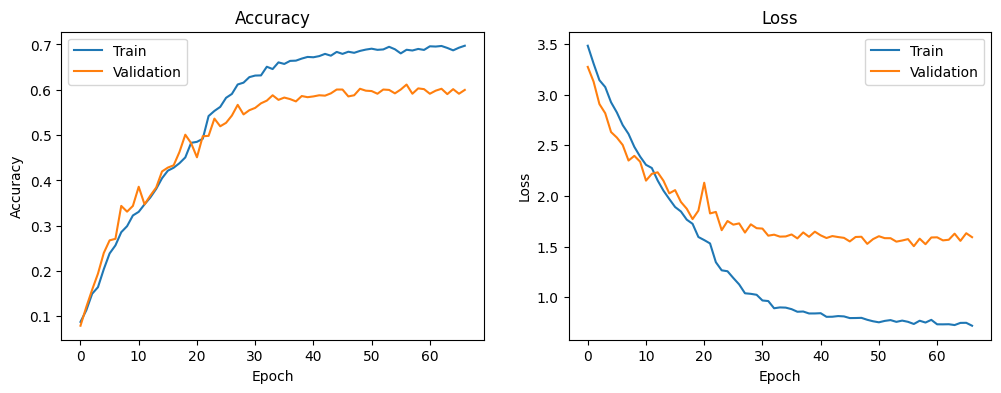

In [30]:
def plot_history(hist):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_history(history)


## Evaluasi di Test Set


In [31]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2026-02-21 16:57:59.222156: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:57:59.222456: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5939 - loss: 1.7116
Test accuracy: 0.5938566327095032
Test loss: 1.7115545272827148


In [18]:
# (Opsional) Classification report (test set)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

2026-02-21 16:31:18.494415: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2026-02-21 16:31:18.494471: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: cHRM chunk does not match sRGB
2026-02-21 16:31:21.782829: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: Number of classes, 47, does not match size of target_names, 48. Try specifying the labels parameter

## Inference (Bukti inferensi untuk submission)
Jalankan cell ini dengan satu gambar contoh dan screenshot outputnya.

In [ ]:
from tensorflow.keras.preprocessing import image

SAMPLE_PATH = None  # <-- ganti ke path gambar contoh, misalnya: "dataset/test/avanza/img_0001.jpg"

if SAMPLE_PATH and os.path.exists(SAMPLE_PATH):
    img = image.load_img(SAMPLE_PATH, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0]
    idx = int(np.argmax(pred))
    print("Predicted:", CLASS_NAMES[idx])
    print("Confidence:", float(pred[idx]))
else:
    print("Set SAMPLE_PATH ke path gambar contoh dulu.")


## Simpan Model ke SavedModel (Wajib)


In [ ]:
SAVED_MODEL_DIR = "saved_model"
model.save(SAVED_MODEL_DIR)
print("SavedModel saved to:", SAVED_MODEL_DIR)

## Convert ke TFLite (Wajib)


In [ ]:
TFLITE_DIR = "tflite"
os.makedirs(TFLITE_DIR, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
# opsional optimisasi ringan:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = os.path.join(TFLITE_DIR, "model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

# simpan label
label_path = os.path.join(TFLITE_DIR, "label.txt")
with open(label_path, "w") as f:
    for name in CLASS_NAMES:
        f.write(name + "\n")

print("TFLite saved to:", tflite_path)
print("Labels saved to:", label_path)

## Convert ke TFJS (Wajib)
Jalankan cell ini di environment yang punya `tensorflowjs`.
Di Colab biasanya bisa: `pip install tensorflowjs`.

In [ ]:
TFJS_DIR = "tfjs_model"
os.makedirs(TFJS_DIR, exist_ok=True)

# Jika belum install:
# !pip -q install tensorflowjs

# Convert via command line
cmd = f"tensorflowjs_converter --input_format=tf_saved_model {SAVED_MODEL_DIR} {TFJS_DIR}"
print("Running:", cmd)
# Uncomment baris di bawah saat dijalankan di notebook (Colab/local shell support)
# !{cmd}

print("TFJS output folder:", TFJS_DIR)

## Struktur folder submission (disarankan)
```
submission/
├── tfjs_model/
├── tflite/
│   ├── model.tflite
│   └── label.txt
├── saved_model/
├── notebook.ipynb
├── README.md
└── requirements.txt
```
